In [1]:
import numpy as np
from numpy import random as rd
import matplotlib as mpl
import matplotlib.pyplot as plt
from RL_tutorial_fns import *
%matplotlib inline

In [2]:
# HELPER FUNCTIONS #
def nice_colors(n):
    return mpl.cm.ScalarMappable(cmap='cool').to_rgba(np.linspace(0, 1, n))

# Reinforcement Learning Tutorial

The whole point of reinforcement learning is to **maximize reward**. 

Here's the set-up:
* You're in an environment, which consists of many possible **states**
* Given your current state, you have to decide what **action** to take
* Taking an action in a given state leads to two consequences:
    * the state you are in may change, and
    * you may get a reward

**The problem of reinforcement is to *explore* the environment and *learn* from your experienced *states* and *rewards* which are the best *actions* to take in each *state*.** Note that no-one ever tells you what the correct action to take is. All you get to see is a reward and a change of state. It is from this very limited data that you have to infer which actions are good and when. This is what makes it *reinforcement* learning rather than *supervised* learning - and what makes it hard!

Here's a simple example:
* You're a mouse in a maze, which has a juicy reward at the center
* You are currently in some particular location in this maze, and have to decide which way to move
* Once you make a decision and move in that direction, you will:
    * change your position in that direction
    * get closer/further to the center of the maze, thus leading to higher/lower probability of obtaining the juicy reward

We'll actually simulate a similar task below.

## 1) Value Estimation

One common approach to doing this is to estimate the **value** of each action at each state. This is the problem we'll solve in most of this notebook. In principle, once you have the value of each action at each state, then at any given state you can just take the action with the highest value and hope you'll be maximizing reward.

The question, of course, is what "value" even means. How should I quantify how good taking a given action at a given state is? One simple answer to this is the instantaneous reward you expect to get from taking this action. But this often leads to bad decisions: the action that provides the highest reward now might drastically reduce the reward you get later on. Think of the [marshmello test](https://www.youtube.com/watch?v=QX_oy9614HQ). Ultimately, our measure of value should include some notion of future reward in addition to immediate reward. We'll explore each of these definitions of value below.

We'll start by considering a very simple task in which there are no actions: the animal experiences a sequence of states and rewards and wants to estimate the value of each state. Extensive experimental evience suggests that animals do this. This is formalized in the so-called **value function** $V(s)$, which gives the value of each possible state $s$.

This value function is unknown before exploring the environment, so our task is to learn it. Our approach will consist of approximating the value function using a *model* $v_\mathbf{w}(s)$ with some set of parameters $\mathbf{w}$. This allows us to now treat this problem as any other typical supervised machine learning problem, whereby we want to find the parameters $\mathbf{w}$ that minimize some loss function. In the reinforcement learning literature, this is referred to as **function approximation**.

## <span style="color:blue"> Classical (Pavlovian) Conditioning </span>

A classic value estimation task is classical conditioning: give the animal a stimulus and then a short time after give them a reward. If you do this enough times, eventually the animal learns to associate this stimulus - also called the **conditioned stimulus (CS)** - with the delivery of a reward some time later. 

One of the first demonstrations of this phenomenon is Ivan Pavlov's experiments with dogs, which is why classical conditioning is often referred to as Pavlovian conditioning. In his classic experiment, he presented the dogs with a sound at a random time, and shortly after gave them a tasty piece of meat. After doing this a couple of times, the dogs would develop a **conditioned response (CR)**, whereby they would salivate as soon as they heard the sound (the conditioned stimulus). This conditioned response reflects the dog having learned an association between the sound and the subsequently delivered tasty meat.

Here's some code for simulating this task:

Text(0, 0.5, 'delivered reward')

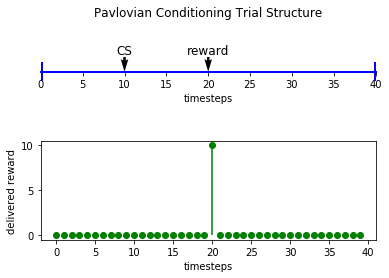

In [3]:
env = classical_conditioning() # create RL environment object

fig, axs = plt.subplots(2, 1)

# Diagram of trial structure
env.illustrate(axs[0])

# Simulate a trial and save reward at each state
reward = np.zeros(env.n_steps) # placeholder
state = 0 # initial state
for s in range(env.n_steps):
    state, reward[s] = env.get_outcome(state) # update state and sample reward

# Plot reward at each timestep
reward_color = 'g'
axs[1].stem(reward, markerfmt='%so'%reward_color, linefmt=reward_color, basefmt='none', use_line_collection=True)
axs[1].set_xlabel('timesteps')
axs[1].set_ylabel('delivered reward')

## <span style="color:blue"> The Rescorla-Wagner Model </span>

An old school and highly influential model of classical conditioning is the Rescorla-Wagner (RW) learning rule. It makes the following assumptions:

1. <u>Value</u>: the value function is defined as the expected instantaneous reward at each state,
\begin{equation}
    V(s) = \mathbb{E}\left[ R(s) \right]
\end{equation}
where $R(s)$ is a random variable following the distribution of rewards at state $s$.

2. <u>Model</u>: function approximation is performed using a linear model,
\begin{equation}
    v_\mathbf{w}(s) = \mathbf{w}^T\phi(s) = \sum_i w_i \phi_i(s)
\end{equation}
where $\phi(s)$ is some representation of the state $s$, which we'll concretize below.

3. <u>Learning</u>: stochastic gradient descent on the mean squared error,
\begin{align}
    \mathcal{L}(\mathbf{w}) &= \frac{1}{2} \left(v_\mathbf{w}(s) - V(s) \right)^2 \\
    \Rightarrow \frac{\partial \mathcal{L}}{\partial \mathbf{w}} &= \left( v_\mathbf{w}(s) - V(s) \right) \frac{\partial v_\mathbf{w}}{\partial \mathbf{w}}(s) \\
    &= \left( v_\mathbf{w}(s) - V(s) \right) \phi(s)
\end{align}
Note that we don't actually know the true value function $V(s)$, so we can't evaluate the gradient. Recall that the value function $V(s)$ is defined as the true mean reward $\mathbb{E}[R(s)]$. Since we don't know the true mean over all possible rewards at state $s$, we'll instead approximate it with a single sample of the reward at state $s$:
\begin{align}
    \frac{\partial \mathcal{L}}{\partial \mathbf{w}} &= \left( v_\mathbf{w}(s) - V(s) \right) \phi(s) \\
    &= \left( v_\mathbf{w}(s) - \mathbb{E}[R(s)] \right) \phi(s) \\
    &\approx \left( v_\mathbf{w}(s) - r(s) \right) \phi(s) \\
    \Rightarrow \Delta \mathbf{w} &= \big( \underbrace{ r(s) - v_\mathbf{w}(s) }_{\delta} \big) \phi(s)
\end{align}
where $r(s)$ is no longer a random variable - it is an actual reward observed at state $s$. The quantity labelled $\delta$ is often referred to as the **reward prediction error**.

The sampling approximation used in step 3 is a classic move in reinforcement learning. Unfortunately, this necessary approximation is one of the reasons why reinforcement learning algorithms scale so badly with the complexity of the environment. If your environment is noisy then you may need many samples of the reward to get an accurate estimate of the gradient.

The resulting reinforcement learning algorithm will thus look like this:
1. Observe the current state $s$ and reward $r(s)$
2. Calculate current estimated value for this state, $v_\mathbf{w}(s)$
3. Update weights according to
\begin{equation}
    \mathbf{w} \rightarrow \mathbf{w} + \alpha \Delta \mathbf{w}
\end{equation}
for some learning rate $\alpha > 0$.
4. Move on to the next state and repeat

It's that easy!

## <span style="color:blue"> Tabular State Representations </span>

One thing we're still missing is a choice of state representation $\phi(s)$. One straight-forward choice used often in simple reinforcement learning problems such as this one is the so-called **tabular representation**, where you just assign some ordering for all possible states $s^{(1)}, \ldots, s^{(M)}$ and represent them with a **one-hot vector**, i.e.
\begin{equation}
    \phi\left(s^{(j)}\right) = 
    \begin{bmatrix}
        \phi_1\left(s^{(j)}\right) \\
        \phi_2\left(s^{(j)}\right) \\
        \vdots \\
        \phi_M\left(s^{(j)}\right)
    \end{bmatrix}
    \quad\quad
    \phi_i(s^{(j)}) = 
    \begin{cases}
        1 & \text{if } i = j \\
        0 & \text{else}
    \end{cases}
\end{equation}

Note that a linear function of a tabular representation just returns one of the elements of the weight vector:
\begin{equation}
    \mathbf{w}^T \phi\left(s^{(j)}\right) = \sum_i w_i \phi_i\left(s^{(j)}\right) = w_j
\end{equation}
Thus, when the value function is linear and your representation is tabular, the $j$th weight in the linear model is exactly equal to the value assigned to the $j$th state $s^{(j)}$. This is why this representation is called *tabular*: your weight vector can now be interpreted as a *table* with the values of each state.

A similar scheme was used by Schultz, Dayan, and Montague '97 to model Pavlovian conditioning. They assumed the relevant state in this task to be the time elapsed since presentation of the conditioned stimulus. They thus discretized time within a trial to some set of discrete timesteps $0, \ldots, T$ and represented each of these states as a one-hot vector if it corresponded to a timepoint after presentation of the conditioned stimulus. 

However, one thing that is missing from this simple representation is the fact that, whereas the time of the reward is perfectly predictable from the time of the conditioned stimulus, the time of the conditioned stimulus is random and unpredictable (recall that it is presented at a random time). Thus, the animal in the experiment has no way of predicting when the conditioned stimulus will occur. For this reason, Schultz and colleages decided to represent the states corresponding to timepoints *before* presentation of the conditioned stimulus as vectors of 0's. That way, these state representations could not possibly contribute to the value prediction, reflecting the fact that these states are equivalently uninformative about value in this task. 

See the next cell for a depiction of this state representation. Each row corresponds to the one-hot vector representing the state indicated on the x-axis (corresponding to timesteps in the task).

For all future exercises, you can use the function `env.tabular_rep(s)` to construct the tabular representation of the state `s`. 

Text(0.5, 1.0, 'Tabular Representations of each State\nin Classical Conditioning Environment')

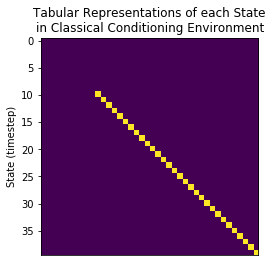

In [4]:
states = np.array([env.tabular_rep(state) for state in env.get_states()])
plt.imshow(states)
plt.xticks([])
plt.ylabel('State (timestep)')
plt.title('Tabular Representations of each State\nin Classical Conditioning Environment')

### 1.1) Estimate the classical conditioning value function using the Rescorla-Wagner learning rule

Most of the code is alreayd written for you - you just need to fill in the acutal updating of the weights. Below the next cell is some code for visualizing the results of this learning algorithm. Answer the following questions:

1. At which state does the final estimated value peak? What meaning does this state have in the task?
2. What happen to the reward prediction errors over trials? How does its peak change over learning?
3. How could this account for Pavlov's dogs' conditioned response in this task?

In [5]:
# Learning Parameters
n_trials = 2000
alpha = 0.01 # learning rate

# Initialize weights
w = np.zeros(env.n_states)

# Placeholders
deltas = np.zeros((env.n_steps, n_trials))

# Loop over trials
for i in range(n_trials):
    
    # Initial state
    state = env.init_state
    
    for t in range(env.n_steps - 1):
        
        # Get next state and reward
        next_state, reward = env.get_outcome(state)
        
        # Calculate current estimate of value of this state
        f = np.dot(w, env.tabular_rep(state)) 
        
        # Calculate reward prediction error
        deltas[t, i] = reward - f
        
        # Update weights
        w += alpha * deltas[t, i] * env.tabular_rep(state)
        
        # Update state
        state = next_state

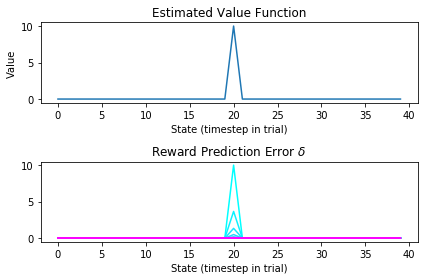

In [6]:
fig, axs = plt.subplots(2, 1)

# Plot estimated value function
ax = axs[0]
states = env.get_states()
V = [np.dot(w, env.tabular_rep(s)) for s in states]
ax.plot(states, V)
ax.set_title('Estimated Value Function')
ax.set_ylabel('Value')
ax.set_xlabel('State (timestep in trial)')

# Plot errors over trials
ax = axs[1]
intervals = 100
indx = np.arange(0, n_trials, intervals)
[ax.plot(np.arange(env.n_steps), deltas[:, i], color=c) for i, c in zip(indx, nice_colors(len(indx)))]
ax.set_title('Reward Prediction Error $\delta$')
ax.set_xlabel('State (timestep in trial)')

plt.tight_layout()

## <span style="color:blue"> Temporal-Difference (TD) Learning </span>

Like we mentioned above, often it is important to take into account future reward when assigning value to a state. Think of the classical conditioning task: even though no reward is received at the time of the conditioned stimulus, it still has value because it is indicative of future reward. Think of a game of chess: a particular move might not take a piece from your opponent or put him in checkmate, but it might get you closer to doing one of these things later on.

To take this into account, reinforcement algorithms typically define the value of a state to be the <u>expected</u> <u>discounted</u> <u>future</u> <u>reward</u>:
\begin{equation}
    V(s) = \mathbb{E} \Bigg[ \sum_{\tau=0}^T \gamma^\tau R \left( S_\tau \right) \Bigg]
\end{equation}
where
* $R(s)$, as before, is a random variable following the distribution of rewards at state $s$
* $S_\tau$ is a random variable following the distribution of the state at $\tau$ timesteps in the future, given that the current state is $s$. $\tau$ thus range from 0 (where the distribution of $S_0$ assigns probability 1 to state $s$) up to the final timestep $T$ in the task, which could in principle be $\infty$.
* $0 \leq \gamma \leq 1$, called the **discount factor**, gauges how much you care about the future. If $\gamma$ is near 0, then future rewards are discounted more and the value reflects the instantaneous reward more than future reward. Conversely, if $\gamma$ is near 1 then the value weighs the future reward almost as much as the instantaneous reward.

This definition of value gives rise to the **temporal difference learning** algorithm. We make the following assumptions:
1. <u>Value</u>: the value function is defined as the expected discounted future reward defined in the above equation

2. <u>Model</u>: can be any differentiable function

3. <u>Learning</u>: stochastic gradient descent on the mean squared error, as in the RW model. In this case, however, the sampling approximation to the value function becomes more complicated: 
\begin{align}
    \frac{\partial \mathcal{L}}{\partial \mathbf{w}} &= \left( v_\mathbf{w}(s) - V(s) \right) v'_\mathbf{w}(s) \\
    &= \left( v_\mathbf{w}(s) - \mathbb{E}\Bigg[ \sum_{\tau=0}^T \gamma^\tau R \left( S_\tau \right) \Bigg] \right) v'_\mathbf{w}(s) \\
    &\approx \left( v_\mathbf{w}(s) - \sum_{\tau=0}^T \gamma^\tau r \left( s_\tau \right) \right) v'_\mathbf{w}(s), \quad v'_\mathbf{w}(s) = \frac{\partial v_\mathbf{w}}{\partial \mathbf{w}}(s)
\end{align}
where $s_\tau$ is the actual observed state $\tau$ timesteps in the future, and $r \left( s_\tau \right)$ is the observed reward at that state.
Whereas before we just had to sample the instantaneous reward at state $s$ to approximate $V(s)$, now we require sampling the entire future timecourse of states and rewards. Doing this is called the **Monte-Carlo algorithm** for value estimation. Note that, since you need to sample an entire timecourse of rewards in order to estimate the gradient, this algorithm requires waiting until the end of the task to update the model parameters. This makes learning very slow, and impossible for environments in which there is no terminal state (i.e. $T = \infty$)! Temporal difference learning gets around this by exploiting the recursive nature of the expected return, illustrated by the **Bellman Equation**:
\begin{align}
    V(s) &= \mathbb{E} \left[ \sum_{\tau=0}^T \gamma^\tau R \left( S_\tau \right)  \right] \\
    &= \mathbb{E} \left[ R \left( S_0 \right) + \sum_{\tau=1}^T \gamma^\tau R \left( S_\tau \right) \right] \\
    &= \mathbb{E} \left[ R \left( S_0 \right) + \gamma\sum_{\tau=0}^{T-1} \gamma^\tau R \left( S_{\tau+1} \right) \right] \\
    &= \mathbb{E}[R \left( S_0 \right)] + \gamma \mathbb{E} \left[\sum_{\tau=0}^{T-1} \gamma^\tau R \left( S_{\tau + 1} \right) \right] \\
    &= \mathbb{E}[R(s)] + \gamma \mathbb{E} \left[ V \left( S_1 \right) \right] \\
\end{align}
This equation suggests we can approximate the true value of state $s$ using two samples: one of the reward $R(s)$ at the current state, and one of the next state $S_1$. However, the second term still requires computing the true value of a state, which we don't know! So we get around this by [**bootsrapping**](https://en.wiktionary.org/wiki/pull_oneself_up_by_one%27s_bootstraps), i.e. by using our own estimate of the value function:
\begin{equation}
    V(s) \approx r(s) + \gamma v_\mathbf{w} \left( s_1 \right)
\end{equation}
where $r(s)$ is the observed reward at the current state $s$ and $s_1$ is the observed state at the next timestep. It is important to note that in order to arrive at this expression we have had to use two approximations instead of one: in addition to approximating the expectations with samples, we have also approximated the true value function with our current model of it. This approach yields the following elegant update equation:
\begin{align}
    \Delta \mathbf{w} &= \big( \underbrace{ r(s) + \gamma v_\mathbf{w} \left( s_1 \right) - v_\mathbf{w}(s) }_{\delta} \big) v'_\mathbf{w}(s)
\end{align}

Because we are making more approximations, the temporal difference learning rule turns out to be *biased*. The reason is that we are choosing how to improve our estimate of the value function by using our estimate of the value function itself! That's like Donald Trump evaluating his own presidency using his own perception of his success - few would argue this evaluation would not be biased. However, unlike Donald's self-evaluations, it turns out that the temporal difference algorithm somewhat miraculously works in practice. In fact it is even guaranteed to converge to the true value function under relatively mild conditions on the structure of the environment and the model. (Dayan, '92)

The temporal difference learning algorithm thus looks like this:
1. Observe the current state $s$ and receive reward $r(s)$
2. Observe the next state $s_1$
3. Calculate estimated value for each of these states, $v_\mathbf{w}(s), v_\mathbf{w} \left( s_1 \right)$
4. Update weights according to
\begin{equation}
    \mathbf{w} \rightarrow \mathbf{w} + \alpha \Delta \mathbf{w}
\end{equation}
for some learning rate $\alpha > 0$.
5. Repeat

[*Footnote*: Note that in the above derivation we bootstrapped only one timestep into the future by sampling $s_1$. We could instead sample $t$ timesteps into future and bootstrap using all of these, hopefully providing us with a better approximation: $V(s) \approx r(s) + \sum_{\tau=1}^t \gamma^\tau v_\mathbf{w} \left( s(t) \right)$. These considerations lead to the more general TD($\lambda$) algorithm, which involves averaging over many bootstrap lengths using eligibility traces and is indeed less biased. The above algorithm is actually called the TD(0) algorithm.]

### 1.2) Estimate the classical conditioning value function using the temporal difference learning rule

Adapt your Rescorla-Wagner code above to implement the TD learning rule on this task, again using a linear model and tabular state representation. Try using a discount factor of $\gamma = .98$. How do your answers to these questions change?

1. At which state does the final estimated value peak? What meaning does this state have in the task?
2. What happen to the reward prediction errors over trials? How does its peak change over learning?
3. How could this account for Pavlov's dogs' conditioned response in this task?

Try to explain the observed results:
* Why does the reward prediction error never go to zero? (Clue: think about the particular state representation we are using)
* How does it change over trials and why?

In [7]:
# Learning Parameters
n_trials = 2000
alpha = 0.01 # learning rate
gamma = .98  # discount factor

# Initialize weights
w = np.zeros(env.n_states)

# Placeholders
deltas = np.zeros((env.n_steps, n_trials))

# Loop over trials
for i in range(n_trials):
    
    # Initial state
    state = env.init_state
    
    for t in range(env.n_steps - 1):
        
        # Get next state and reward
        next_state, reward = env.get_outcome(state)
        
        # Calculate current estimate of value of this state
        f = np.dot(w, env.tabular_rep(state)) 
        
        # Calculate current estimate of value of next state
        fnext = np.dot(w, env.tabular_rep(next_state))
        
        # Calculate reward prediction error
        deltas[t, i] = reward + gamma * fnext - f
        
        # Update weights
        w += alpha * deltas[t, i] * env.tabular_rep(state)
        
        # Update state
        state = next_state

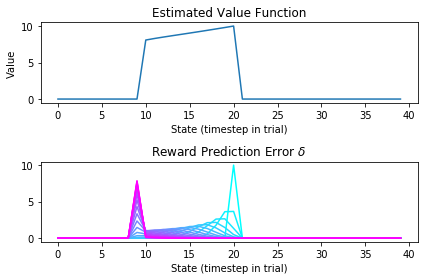

In [8]:
fig, axs = plt.subplots(2, 1)

# Plot estimated value function
ax = axs[0]
states = env.get_states()
V = [np.dot(w, env.tabular_rep(s)) for s in states]
ax.plot(states, V)
ax.set_title('Estimated Value Function')
ax.set_ylabel('Value')
ax.set_xlabel('State (timestep in trial)')

# Plot errors over trials
ax = axs[1]
intervals = 100
indx = np.arange(0, n_trials, intervals)
[ax.plot(np.arange(env.n_steps), deltas[:, i], color=c) for i, c in zip(indx, nice_colors(len(indx)))]
ax.set_title('Reward Prediction Error $\delta$')
ax.set_xlabel('State (timestep in trial)')

plt.tight_layout()

### 1.3) Using the learned model, simulate prediction errors in trials with and without reward

Take the parameters you learned in exercise 1.3 and use them to simulate what reward prediction errors would look like during a trial of classical conditioning if you fixed your value function estimate to this learned model. In particular, simulate what the prediction errors would look like in a trial where the reward is delivered normally and in a trial where the reward is omitted. Compare these prediction errors to those that were produced before learning, using the initial unleared initial model parameters.

Compare your results to the following [PSTH](https://en.wikipedia.org/wiki/Peristimulus_time_histogram)'s of recorded dopaminergic neurons in the primate ventral tegmental area during a classical conditioning task:

<img src="SchultzDayanMontagueFig.png" style="height: 150px;"/>


Repeat this exercise with the model parameters learned in exercise 1.2, using the Rescorla-Wagner learning rule (note that when $\gamma = 0$ the TD learning rule is exactly equivalent to the Rescorla-Wagner learning rule!). Which learning rule seems to explain the recordings better?

In [9]:
# Placeholders
deltas_test = np.zeros(env.n_steps - 1)
deltas_test_omit = np.zeros(env.n_steps - 1)

# Simulate a trial
state = env.init_state
for t in range(env.n_steps - 1):
    
    # Sample next state
    next_state, reward = env.get_outcome(state)
    
    # Calculate current estimate of value
    f = np.dot(w, env.tabular_rep(state))
    fnext = np.dot(w, env.tabular_rep(next_state))

    # Calculate prediction error with reward
    deltas_test[t] = reward + gamma * fnext - f

    # Calculate prediction error with reward omitted
    deltas_test_omit[t] = gamma * fnext - f
    
    # Update state
    state = next_state

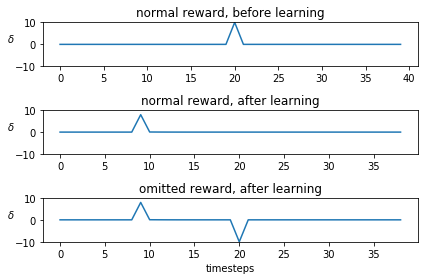

In [10]:
# Create axes
fig, axs = plt.subplots(3, 1)
axlim = [-env.reward_magnitude, env.reward_magnitude]

# Plot reward prediction error on very first trial of experiment, before learning
ax = axs[0]
ax.plot(deltas[:, 0]) # take the first slice of the deltas recorded in code from exercise 1.1, 1.2
ax.set_title('normal reward, before learning')

# Plot reward prediction error after learning, with normal reward
ax = axs[1]
ax.plot(deltas_test)
ax.set_title('normal reward, after learning')

# Plot reward prediction error after learning, with omitted reward
ax = axs[2]
ax.plot(deltas_test_omit)
ax.set_title('omitted reward, after learning')

# Formatting
[ax.set_ylabel('$\\delta$', rotation=0) for ax in axs]
[ax.set_ylim(axlim) for ax in axs]
axs[2].set_xlabel('timesteps')

plt.tight_layout()

### 1.4) Repeat exercise 1.3 with different values of $\gamma$. How do the results change?

Try plotting the reward prediction errors over training and the final learned value function for each setting of $\gamma$. Interpret the observed differences in terms of how the definition of *value* changes with $\gamma$.

Clue: try writing a function that performs the TD learning algorithm with a given setting of $\gamma$ and then spits out the learned value function weights and observed prediction errors.

In [11]:
# Define a function that runs the TD learning algorithm with a given gamma
def TD_learning(gamma):

    # Parameters
    n_trials = 2000
    alpha = 0.01 # learning rate

    # Initialize weights
    w = np.zeros(env.n_states)

    # Placeholders
    deltas = np.zeros((env.n_steps, n_trials))

    # Loop over trials
    for i in range(n_trials):

        # Initial state
        state = env.init_state

        for t in range(env.n_steps - 1):

            # Get next state and reward
            next_state, reward = env.get_outcome(state)

            # Calculate current estimate of value of this state
            f = np.dot(w, env.tabular_rep(state)) 

            # Calculate current estimate of value of next state
            fnext = np.dot(w, env.tabular_rep(next_state))

            # Calculate reward prediction error
            deltas[t, i] = reward + gamma * fnext - f

            # Update weights
            w += alpha * deltas[t, i] * env.tabular_rep(state)

            # Update state
            state = next_state

    # Return reward prediction errors over learning and the learned weights
    return deltas, w

In [12]:
# Run TD learning with different gammas and save the reward prediction errors and learned weights
gammas = [0.1, 0.5, 0.75, 0.9, 0.99]
deltas = []
weights = []
for gamma in gammas:
    d, w = TD_learning(gamma)
    deltas.append(d)
    weights.append(w)

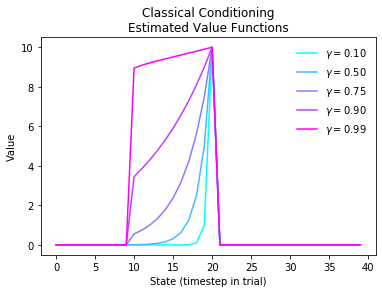

In [13]:
# Compare value functions
fig, ax = plt.subplots()
for w, g, col in zip(weights, gammas, nice_colors(len(gammas))):
    states = env.get_states()
    V = [np.dot(w, env.tabular_rep(s)) for s in states]
    ax.plot(states, V, color=col, label='$\gamma = %.2f$' % g)

ax.set_title('Classical Conditioning\nEstimated Value Functions')
ax.set_xlabel('State (timestep in trial)')
ax.set_ylabel('Value')
ax.legend(frameon=False)

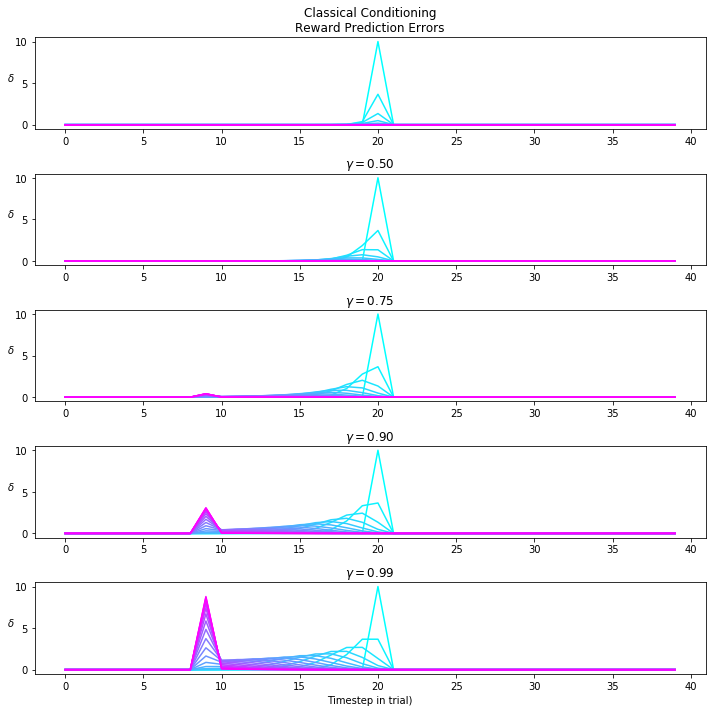

In [14]:
# Compare value functions
fig, axs = plt.subplots(len(gammas), 1, figsize=(10, len(gammas) * 2))
plot_intervals = 100
plot_index = np.arange(0, deltas[0].shape[1], plot_intervals)
for d, g, ax in zip(deltas, gammas, axs):
    [ax.plot(np.arange(env.n_steps), d[:, i], color=c) for i, c in zip(plot_index, nice_colors(len(plot_index)))]
    ax.set_title('$\gamma = %.2f$' % g)
    ax.set_ylabel('$\delta$', rotation=0)

axs[0].set_title('Classical Conditioning\nReward Prediction Errors')
axs[-1].set_xlabel('Timestep in trial)')
plt.tight_layout()

## 2) Action Value Estimation

Let's now incorporate actions into our environment. Rather than estimating the value of a single state, we're now interested in estimating the value of a given action at a given state, also called an **action value**, or **Q value**:
\begin{equation}
    Q(s, a) = \mathbb{E} \Bigg[ \sum_{\tau=0}^T \gamma^\tau R \left( S_\tau, A _\tau \right) \Bigg]
\end{equation}
where now the distribution of the reward $R$ depends on both the state $S$ and the action $A$ taken at that state. The random variables $S_\tau, A_\tau$ are distributed according to the state transitions induced by the states visited and actions taken.

Exactly as above, we can use TD learning to estimate this Q-value function by learning a model $q_\mathbf{w}(s, a)$ that minimizes the boostrapped squared error:
\begin{equation}
    \Delta \mathbf{w} = \big( \underbrace{ r(s, a) + \gamma q_\mathbf{w} \left( s_1, a_1 \right) - q_\mathbf{w}(s, a) }_\delta \big) q'_\mathbf{w}(s, a), \quad q'_\mathbf{w}(s, a) = \frac{\partial q_\mathbf{w}}{\partial \mathbf{w}}(s, a)
\end{equation}
where $s, a, r(s, a)$ are respectively the state visited, action taken, and reward recieved at the current timestep, and $s_1, a_1$ are respectively the state observed and action taken in the next timestep. Because the resulting algorithm requires taking a sample of the current \*S\*tate, \*A\*ction, and \*R\*eward followed by a sample of the next \*S\*tate and \*A\*ction, it is aptly named SARSA.

[*Footnote*: If we knew the structure of the environment perfectly, i.e. knew which actions led to which states, we could try to learn the distribution of rewards at each state and then exploit our knowledge of the state transition structure to choose the right actions. This is called **model-based** learning. Unfortunately, if you don't know the structure, in many cases learning it turns out to be pretty hard, so we won't cover this. Instead we'll focus on **model-free** learning.]

## <span style="color:blue"> $\epsilon$-greedy Policy </span>

As we said above, we'd like to take the actions that have highest value in any given state. Such a **greedy policy** would be useful once we knew the action values, but until we know them it will be important to ensure we have some exploratory behavior as well so that we don't miss out on any better actions we might have missed. To do this, we'll use what is called an **$\epsilon$-greedy policy** $\pi_s(a)$, which determines the probability distribution of the chosen action $A$ given the current state $S$:
\begin{equation}
    \pi_s(a) = P \big( A = a | S = s \big) = 
    \begin{cases}
    1 - \epsilon + \frac{\epsilon}{m} & \text{if }a = \arg\max_b q_\mathbf{w}(s, b) \\
    \frac{\epsilon}{m} & \text{else}
    \end{cases}
\end{equation}
where $m$ is the number of possible actions. In English: with probability $\epsilon$ pick a random action, otherwise pick the action with the highest value, i.e. $\arg\max_b q_\mathbf{w}(s, b)$. The larger $\epsilon$ is, the less greedy and the more exploratory the policy is.

I have already provided a function called `epsilon_greedy(action_values, epsilon)` that takes as arguments the action values (in order to be able to pick the greedy action with probability 1-$\epsilon$) and the exploration parameter $\epsilon$, and returns an action sampled from the policy $\pi_s(a)$.

## <span style="color:blue"> Maze Task </span>

We'll now try to navigate a kind of maze environment where the learning agent starts at a fixed starting position and has to reach a goal location. The maze has a few walls that can't be crossed, and the agent will receive a reward of -1 at each timestep. If the goal location is reached, a reward of +100 is delivered. Thus, to maximize reward in this task the agent must find a way to reach the goal location in as few timesteps as possible.

The next cell provides some code for visualizing the maze structure and generating random trajectories on it. The blue squares correspond to the walls that cannot be crossed, and the red square corresponds to the goal location. The purple, green, and orange lines are three random trajectories generated by a random sequence of actions (left/right/up/down).

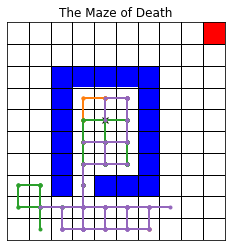

In [15]:
env = maze_task(wall=True)

fig, ax = plt.subplots()

# Plot the maze map
env.illustrate(ax)

# Simulation parameters
tsteps = 100  # length of each trajectory
qvalues = np.zeros((env.n_actions, env.n_states)) # Q-values used for policy
colors = plt.cm.ScalarMappable(cmap='tab10').to_rgba(np.arange(10))[np.array([1, 2, 4])]

# Overlay simulated trajectories and plot actions and rewards taken and received in each one
for col in colors:

    # Simulate random trajectories under epsilon-greedy policy according to given Q-values
    traj, actions, rewards = env.simulate_trajectory(qvalues, tsteps=tsteps)
    
    # Overlay trajectory on map
    ax.plot(traj[0], traj[1], '.-', color=col, lw=2)

### 2.1) Learn action values for the maze task using SARSA

Use the SARSA algorithm outlined above to learn the action values for the maze task. Most of the code is provided, you just need to provide the parameter updates. Use a tabular representation of state, so that
\begin{equation}
    q_\mathbf{W}(s, a) = [\mathbf{W} \phi(s)]_a = \mathbf{w}_a^T \phi(s) \\
    \frac{\partial q_\mathbf{W}}{\partial \mathbf{w}_b}(s, a) = 
    \begin{cases}
    \phi(s) & \text{if } b = a \\
    0 & \text{else}
    \end{cases}
\end{equation}
where $\mathbf{W}$ is now a matrix, with the $a$th row given by $\mathbf{w}_a^T$. Given a tabular state representation (i.e. $\phi(s)$ is a one-hot vector), you can think of $\mathbf{w}_a$ as a table with the action-values of action $a$ at each state, so that the full matrix $\mathbf{W}$ is a larger table whose element in the $i$th row and $j$th column is the action value of action $i$ in state $j$.

The cell the next one provides code for visualizing the learned greedy policy, by showing the action with highest action value at each state and simulating trajectories in this environment generated by using these actions. Note that the greedy policy is purely deterministic so long as a single action has the highest action value in each state. If, on the other hand, the highest aciton value at a state is shared between two actions, then one of the two will be sampled randomly.

Text(0, 0.5, 'cumulative reward')

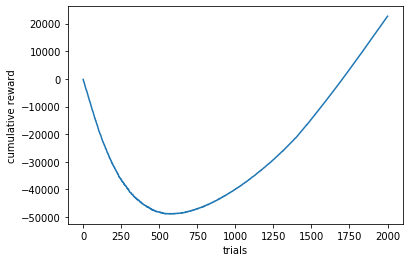

In [16]:
# Learning Parameters
n_trials = 2000
alpha = 0.01  # learning rate
gamma = .98  # discount factor
eps = 0.1  # epsilon-greedy exploration parameter
tsteps_max = 200  # max duration of a trial

# Initialize weights
w = np.zeros((env.n_actions, env.n_states))

# Placeholders
total_reward = np.zeros(n_trials) # keep track of total reward in each trial

# Loop over trials
for i in range(n_trials):
    
    # Initial state
    state = env.init_state
    
    # Pick initial action
    q = np.matmul(w, env.tabular_rep(state))  # estimated action values of current state
    action = epsilon_greedy(q, epsilon=eps)
    
    for t in range(tsteps_max):
        
        # Get next state, reward
        next_state, reward = env.get_outcome(state, action)
        total_reward[i] += reward
        
        # Calculate current estimate of action values of next state
        if next_state is None:
            next_q = np.zeros(env.n_actions) # next state is None means that trial has ended, so future reward is 0
        else:
            next_q = w @ env.tabular_rep(next_state)
        
        # Pick next action
        next_action = epsilon_greedy(next_q, epsilon=eps)
        
        # Calculate reward prediction error
        delta = reward + gamma * next_q[next_action] - q[action]
        
        # Update weights
        w[action] += alpha * delta * env.tabular_rep(state)
        
        # Update state and action
        if next_state is None:
            break
        else:
            state = next_state
            action = next_action
            q = next_q

# Plot cumulative error over learning
fig, ax = plt.subplots()
ax.plot(np.arange(n_trials) + 1, np.cumsum(total_reward))
ax.set_xlabel('trials')
ax.set_ylabel('cumulative reward')

Text(0.5, 1.0, 'Example Trajectories Under\nLearned Greedy Policy')

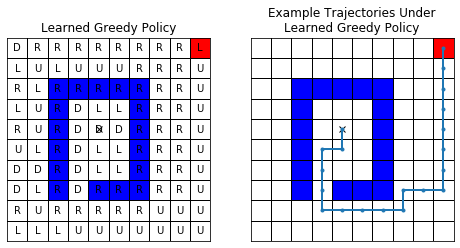

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 16))

# Visualize the learned greedy policy
ax = axs[0]
env.illustrate(ax) # draw maze map
for state in env.get_states():
    Q = np.matmul(w, env.tabular_rep(state))
    coord = env.coord_rep(state)
    ax.text(coord[0], coord[1], env.get_actions(rep='label')[np.argmax(Q)], horizontalalignment='center', verticalalignment='center')
ax.set_title('Learned Greedy Policy')

# Draw trajectories of behavior according to greedy policy
ax = axs[1]
env.illustrate(ax) # draw maze map
Q_matrix = w @ np.array([env.tabular_rep(state) for state in env.get_states()])
traj, actions, rewards = env.simulate_trajectory(Q_matrix, tsteps=500, epsilon=0)
ax.plot(traj[0], traj[1], '.-', lw=2)
ax.set_title('Example Trajectories Under\nLearned Greedy Policy')

## <span style="color:blue"> Off-policy Learning </span>

Recall that we used an $\epsilon$-greedy policy during learning in order to be able to explore the environment. But after learning, there is no point in doing exploration - we just want to use our learned action values to maximize reward. From the perspective of bootstrapping, this is a bit odd - we're estimating the future discounted reward using an $\epsilon$-greedy policy, but in fact the actual future discounted reward after learning will depend on a purely greedy policy. 

One way of resolving this conflict is **off-policy** learning: use an exploratory policy to explore the environment, but when bootstrapping use the actual policy you'll use after learning. Such algorithms are commonly described as "learning by looking over someone's shoulder" - that someone is an agent navigating the environment using an exploratory policy, while you learn to optimize your own greedy policy by observing the outcomes of the agent's exploration. 

One commonly used off-policy learning algorithm is the **Q-learning** algorithm: use an $\epsilon$-greedy policy to ensure you explore the environment during learning, but bootstrap using an purely greedy policy:
\begin{gather}
    \Delta \mathbf{w} = \big( \underbrace{ r(s, a) + \gamma q_\mathbf{w} \left( s_1, a^* \right) - q_\mathbf{w}(s, a) }_\delta \big) q'_\mathbf{w}(s, a) \\
    a^* = \arg\max_b q_\mathbf{w}(s_1, b)
\end{gather}
The only difference between this update that used in the SARSA algorithm is that the second sampled action $a_1$ is replaced by the greedy action $a^*$. This is why the Q-learning algorithm is sometimes referred to as SARSAMAX.

The Q-learning algorithm thus looks like this:
1. Observe the current state $s$ and pick an action $a$ using the *exploratory policy* (e.g. an $\epsilon$-greedy policy)
2. Receive reward $r$ and observe the next state $s_1$
3. Calculate estimated action-value for the next state under the action implied by the greedy policy and use this to compute the reward prediction error
\begin{equation}
    a^* = \arg\max_b q_\mathbf{w}(s_1, b) \\
    \delta = r + \gamma q_\mathbf{w} \left( s_1, a^* \right) - q_\mathbf{w}(s, a)
\end{equation}
4. Update weights according to
\begin{equation}
    \mathbf{w} \rightarrow \mathbf{w} + \alpha \Delta \mathbf{w}
\end{equation}
for some learning rate $\alpha > 0$, where, as before,
\begin{equation}
    \Delta \mathbf{w} = \delta \, q'_\mathbf{w}(s, a)
\end{equation}
5. Repeat

### 2.2) Learn action values for the maze task using the Q-Learning algorithm

Adapt the code from exercise 2.1 to learn the maze task action values using the Q-learning algorithm with a linear model and tabular state representation. Note that off-policy learning implies that that the action you use for bootstrapping when computing the reward prediction error is not the same action you take in the next timestep!

Try playing with the learning parameters and comparing Q-learning to SARSA - which one learns faster?

Text(0, 0.5, 'cumulative reward')

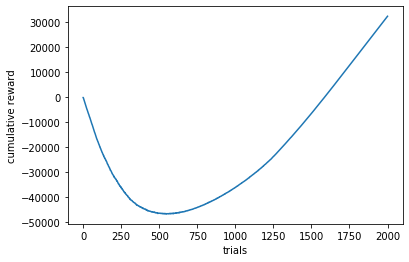

In [18]:
# Learning Parameters
n_trials = 2000
alpha = 0.01  # learning rate
gamma = .98  # discount factor
eps = 0.1  # epsilon-greedy exploration parameter
tsteps_max = 200  # max duration of a trial

# Initialize weights
w = np.zeros((env.n_actions, env.n_states))

# Placeholders
total_reward = np.zeros(n_trials) # keep track of total reward in each trial

# Loop over trials
for i in range(n_trials):
    
    # Initial state
    state = env.init_state
    
    for t in range(tsteps_max):
        
        # Calculate current estimate of action values of current state
        q = w @ env.tabular_rep(state)
        
        # Pick current action according to epsilon-greedy policy
        action = epsilon_greedy(q, epsilon=eps)
        
        # Get next state, reward
        next_state, reward = env.get_outcome(state, action)
        total_reward[i] += reward
        
        # Calculate current estimate of action values of next state
        if next_state is None:
            next_q = np.zeros(env.n_actions) # next state is None means that trial has ended, so future reward is 0
        else:
            next_q = w @ env.tabular_rep(next_state)
        
        # Calculate reward prediction error
        delta = reward + gamma * next_q[np.argmax(next_q)] - q[action]
        
        # Update weights
        w[action] += alpha * delta * env.tabular_rep(state)
        
        # Update state
        if next_state is None:
            break
        else:
            state = next_state

# Plot cumulative error over learning
fig, ax = plt.subplots()
ax.plot(np.arange(n_trials) + 1, np.cumsum(total_reward))
ax.set_xlabel('trials')
ax.set_ylabel('cumulative reward')

Text(0.5, 1.0, 'Example Trajectories Under\nLearned Greedy Policy')

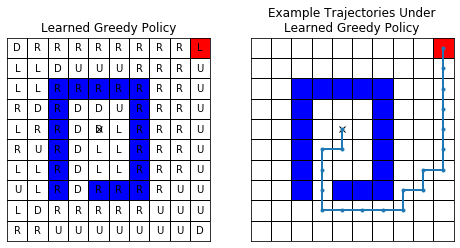

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 16))

# Visualize the learned greedy policy
ax = axs[0]
env.illustrate(ax) # draw maze map
for state in env.get_states():
    Q = np.matmul(w, env.tabular_rep(state))
    coord = env.coord_rep(state)
    ax.text(coord[0], coord[1], env.get_actions(rep='label')[np.argmax(Q)], horizontalalignment='center', verticalalignment='center')
ax.set_title('Learned Greedy Policy')

# Draw trajectories of behavior according to greedy policy
ax = axs[1]
env.illustrate(ax) # draw maze map
Q_matrix = w @ np.array([env.tabular_rep(state) for state in env.get_states()])
traj, actions, rewards = env.simulate_trajectory(Q_matrix, tsteps=500, epsilon=0)
ax.plot(traj[0], traj[1], '.-', lw=2)
ax.set_title('Example Trajectories Under\nLearned Greedy Policy')